# Redes Neuronales Convolucionales (CNN)

Son un tipo de redes neuronales específicamente diseñadas y creadas para tratar con información que tiene topología o estructura de cuadrícula, como series de tiempo y sobre todo, imágenes.

Estas redes neuronales se caracterizan por emplear la _convolución_ para aprender las características más básicas de las imágenes que se le suministran, con lo que pueden generalizar los elementos e identificar estructuras muy variadas a partir de estos bloques elementales.

## Sobre la convolución

Siguiendo el libro [Deep Learning](https://www.deeplearningbook.org/), la operación que emplean las CNN no es técnicamente la convolución sino una operación muy semejante llamanda [relación cruzada (cross-relation)](https://en.wikipedia.org/wiki/Cross-correlation), que es igual a la convolución en un caso particular.

La razón de esto es porque computacionalmente es más eficiente programar y ejecutar la _relación cruzada_ que la convolución directamente, y esto es a lo que se le llama _convolución_ en _deep learning._

## Caso de estudio: Clasificación de MNIST

Para este documento se pretende clasificar el conjunto MNIST con una CNN básica, donde se proponen un par de estructuras elementales como las capas de convolución y de _pooling_. La idea es generar una CNN elemental que demuestre y explique la implementación en `keras`.

In [62]:
from keras import layers, models, datasets, utils
import matplotlib.pyplot as plt

## Hiperparámetros de la CNN

Para comenzar se fijarán algunos hiperparámetros de la CNN, en esto caso se toma como ejemplo el [ejercicio de `keras` sobre CNN](https://keras.io/examples/mnist_cnn/) y se va a modificar para este documento.

Los hiperparámetros se quedan igual, sobre todo el tamaño de las imágenes.

In [63]:
# Tamaño de lote para el optimizador
batch_size = 128
# Número de clases, ya se sabe por que se conoce el conjunto de datos
# pero si no, se puede hacer de forma programática
num_classes = 10
# Número de épocas, dejar como está porque es suficiente
epochs = 12

# Tamaño de las imágenes, ancho y alto
img_rows, img_cols = 28, 28

## Importar los datos

Se extraen los datos desde la API de `keras` la cual ya separa el conjunto de datos en entrenamiento y prueba. En total el conjunto de datos consta de 70000 imágenes y aquí se separan en 60000 de entrenamiento y 10000 de prueba.

In [64]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [77]:
# Para verificar el tamaño de las imágenes y el número de imágenes
x_train.shape

(60000, 28, 28, 1)

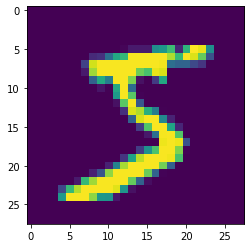

In [66]:
# Se puede visualizar una de estas imágenes para conocer el conjunto de datos
plt.imshow(x_train[0, :, :])

## Preprocesamiento de datos

Ahora se deben ajustar los datos de entrada para que sean consistentes con las capas de la CNN en `keras`. En este caso se va a agregar una dimensión adicional hasta el final del _tensor_ de datos para afirmar que existe solamente un canal de colores.

El tamaño de las imágenes es ahora **(número de ejemplos, ancho, alto, número de canales)** en ese orden.

In [67]:
# Reajustar las imágenes para asegurar que solamente es un canal de color
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# Tamaño de la entrada, en forma de tupla siempre
input_shape = (img_rows, img_cols, 1)

Un paso adicional para asegurar que todo es consistente es convertir los datos a `float32` para mejor manejo con el CPU/GPU (recordar que las GPU solamente pueden trabajar con flotantes de 32 bits).

Adicionalmente, se normalizan las entradas para dejar en flotantes los valores de cada pixel, dividiendo por el total que pueden adquirir como valor. Esto para seguir con el manejo de la CNN y consistencia a lo largo del entrenamiento y evaluación.

In [68]:
# Convertir a float32 para mejor manejo
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
# Normalizar los valores de las imágenes
x_train /= 255
x_test /= 255

In [69]:
print("Tamaño del conjunto de entrenamiento:", x_train.shape)
print(x_train.shape[0], "Muestras de entrenamiento")
print(x_test.shape[0], "Muestras de prueba")

Tamaño del conjunto de entrenamiento: (60000, 28, 28, 1)
60000 Muestras de entrenamiento
10000 Muestras de prueba


Con esto nos aseguramos de todos los pasos que hemos hecho hasta ahora. Todo parece estar en orden, teniendo 60000 imágenes de entrenamiento y 10000 de prueba.

El último paso de preprocesamiento es hacer la codificación _one-hot_ para las etiquetas, que se puede realizar fácilmente en `keras`, o alternativamente en `scikit-learn`.

In [70]:
# One Hot encoding para las etiquetas
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [79]:
# Está representación dice que esta entrada en particular pertenece al
# dígito 6 en el conjunto de datos
y_train[0, :]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Arquitectura de la CNN

Siguiendo el ejemplo de `keras` se toma la siguiente arquitectura:

- La **entrada** consta de una capa convolucional de 32 unidades. El _kernel_ de convolución es de $3 \times 3$ y tiene una función de activación ReLU. No tiene **relleno** en los bordes, por lo que al final de esta capa el tamaño de las imágenes se verá reducido.

- La **primera capa oculta** consta de una capa convolucional de 64 unidades, con un _kernel_ de $3 \times 3$ y función de activación ReLU. Después de esto se aplica una capa de agrupación o _pooling_ de tipo máximo, lo que seleccionará el máximo valor entre los 2 vecinos más cercanos, en este caso en particular.

- La **segunda capa oculta** consta de un _aplanamiento_ espacial de las imágenes, lo que las hará vectores unidimensionales, y una red neuronal totalmente conectada de 128 unidades con función de activación ReLU.

- La **capa de salida** consta del número total de clases y la función de activación _softmax_ para clasificación.

Este diseño consta entonces de dos partes, la primera parte para aprender **características** mediante las dos capas convolucionales, y la última parte con dos capas para la **clasificación** efectiva del conjunto de datos.

In [71]:
arquitectura = [
    layers.Conv2D(32, kernel_size=(3, 3),
                 activation="relu",
                 input_shape=input_shape),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
]

In [72]:
# Se construye el modelo con este diseño
model = models.Sequential(arquitectura)

### Optimización y entrenamiento

Para optimizar y medir la eficacia de este modelo se optó por el optimizador [NADAM](http://cs229.stanford.edu/proj2015/054_report.pdf) que facilita el aprendizaje en arquitecturas grandes al tener un ratio de aprendizaje autoajustable, y la _precisión_ como medida de clasificación.

In [73]:
model.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

Ahora se entrena el modelo, separando un 20% del conjunto de entrenamiento como conjunto de validación, para dejar el conjunto de prueba como evaluación de la generalización del modelo.

In [74]:
%%time
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 53s 1ms/step - loss: 0.1617 - acc: 0.9508 - val_loss: 0.0559 - val_acc: 0.9846
Epoch 2/12
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0417 - acc: 0.9873 - val_loss: 0.0485 - val_acc: 0.9850
Epoch 3/12
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0244 - acc: 0.9923 - val_loss: 0.0452 - val_acc: 0.9871
Epoch 4/12
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0459 - val_acc: 0.9877
Epoch 5/12
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0105 - acc: 0.9964 - val_loss: 0.0529 - val_acc: 0.9862
Epoch 6/12
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0102 - acc: 0.9966 - val_loss: 0.0510 - val_acc: 0.9888
Epoch 7/12
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0074 - acc: 0.9975 - val_loss: 0.0569 - val_acc

Si se observa el valor de `acc`, la precisión en el conjunto de entrenamiento, y `val_acc` la precisión en el conjunto de validación, existe una diferencia notable, con 99.6% y 98.7% en promedio, respectivamente.

Esto implica que el modelo está **sobreajustado**, y aunque pareciera que son algunos decimales, en realidad está _bastante_ **sobreajustado**. Para comprobar este resultado, se evaluará el modelo entrenado en el conjunto de prueba que se reservó desde el principio, recordando que este conjunto nunca fue visto por el modelo; con esto se podrá comprobar la verdadera generalización del modelo.

In [76]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Pérdida general del conjunto de prueba:", score[0])
print("Precisión del conjunto de prueba:", score[1])

Pérdida general del conjunto de prueba: 0.04712263136188756
Precisión del conjunto de prueba: 0.9899


Como era de esperarse, la _precisión_ en el conjunto de prueba se parece más al valor encontrado por la precisión del conjunto de validación, esto es el valor de `val_acc` en el modelo antes mostrado.

Esto demuestra que el modelo está efectivamente **sobreajustado**, y no por un margen pequeño (aunque lo parezca).

La pregunta aquí es: ¿qué se puede hacer para mejorarlo? ¿Esto se debe al diseño de la CNN? ¿Se debe a la elección de hiperparámetros?

## Ejercicios

- La arquitectura de esta CNN no es única, ¿será posible mejorar el valor de precisión? Modificar el número de unidades en las capas excepto la salida para comprobar si esto es posible.

- El sobreajuste del modelo se puede deber a varias razones, ¿cuáles son las más probables?

- Cada capa convolucional, al no tener relleno, reduce el tamaño de cada imágen. Calcular estos tamaños y el tamaño final del vector de información para saber el efecto de tener relleno o no. ¿Qué pasaría si se le pone relleno? Experimentar con las opciones de relleno en `keras`.

- La capa de _pooling_ no es única, modificar usando las distintas implementaciones de `keras`. ¿Esto afecta positivamente al resultado del modelo?